In [12]:
from matplotlib.patches import Patch
from collections import defaultdict
from __future__ import annotations
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm
import seaborn as sns
import numpy as np


env = gym.make("Blackjack-v1", sab=True)

In [120]:
done = False
observation, info = env.reset()
observation

#La tupla indica la somma delle carte del giocatore, la carta scoperta del banco e se il giocatore ha un asso (1 o 0)

(12, 6, 0)

In [14]:
action = env.action_space.sample()
action


np.int64(1)

In [15]:

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

In [32]:
action = env.action_space.sample()
action

np.int64(0)

In [17]:
class BlackjackAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, env, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [ ]:

# hyperparameters
learning_rate = 0.001
n_episodes = 1_000_000
start_epsilon = 1
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [19]:
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(env, obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 1000000/1000000 [02:09<00:00, 7739.94it/s]


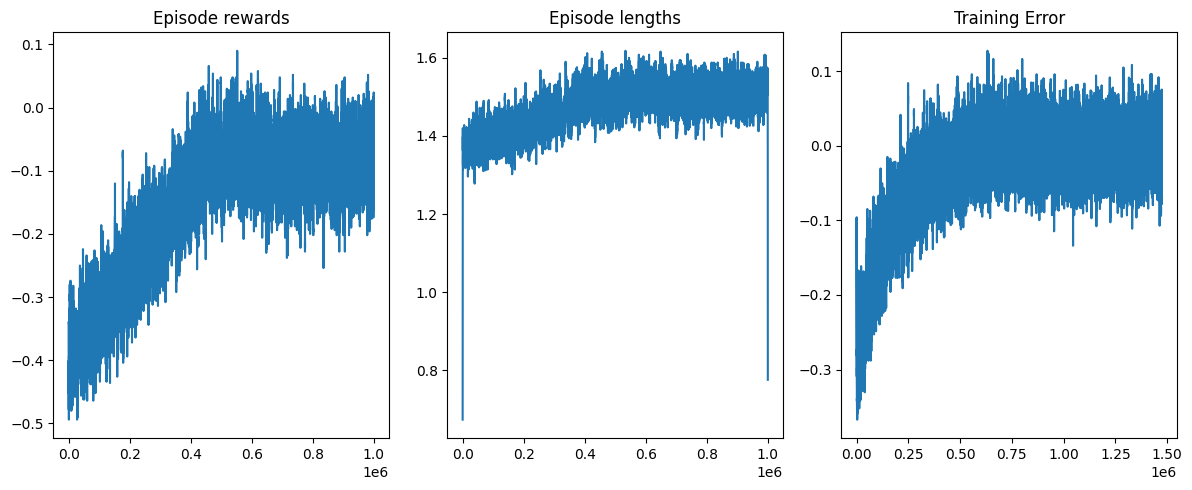

In [20]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

C:\Users\placi\AppData\Local\Temp\ipykernel_1936\1408719560.py:94: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  value_fig.show()
C:\Users\placi\AppData\Local\Temp\ipykernel_1936\1408719560.py:95: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  policy_fig.show()


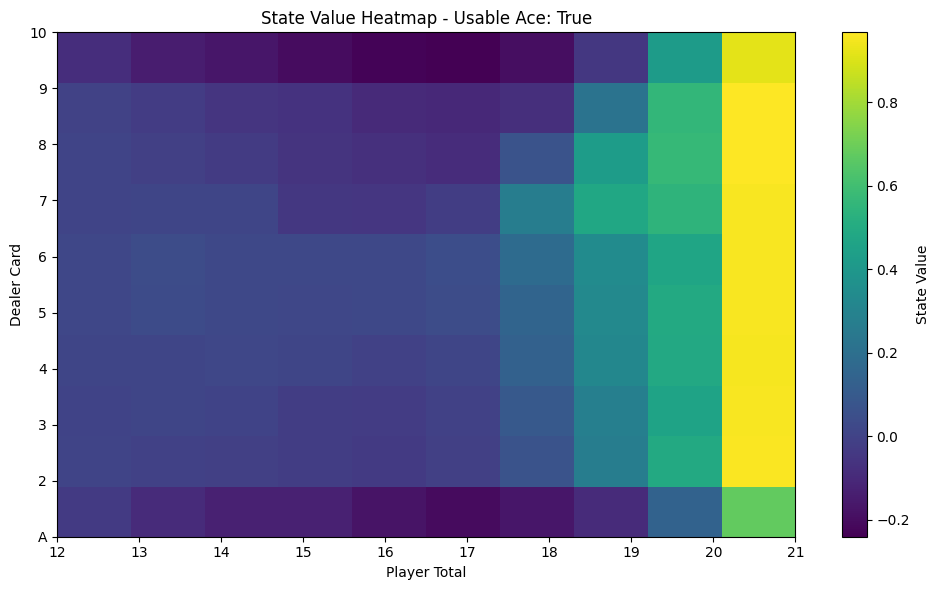

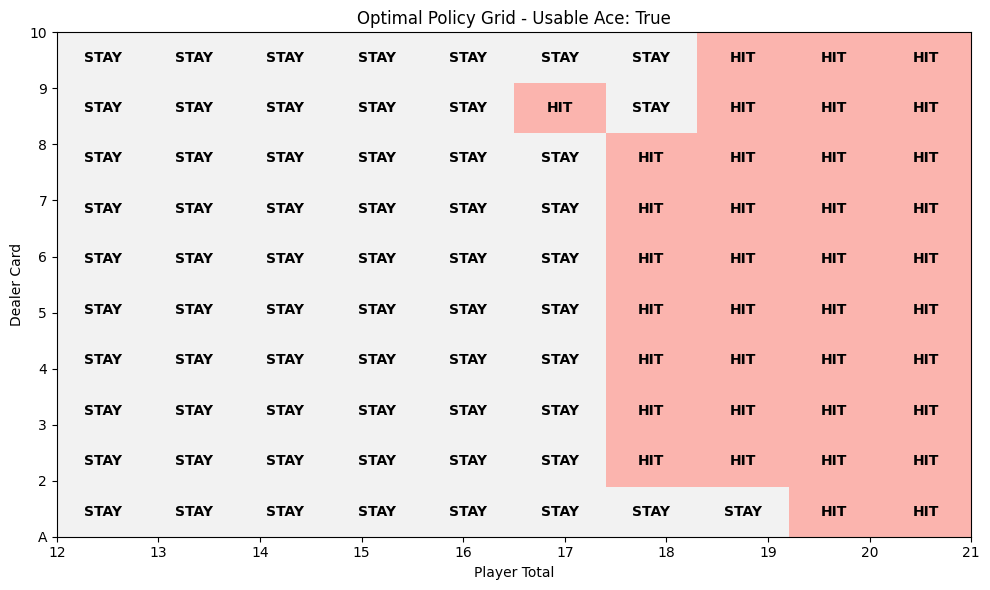

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_value_heatmap(q_agent, has_usable_ace=True):
    """Generates a heatmap visualization of state values."""
    # Extract state values from Q-agent
    state_values = {}
    for state, actions in q_agent.q_values.items():
        state_values[state] = np.max(actions)
    
    # Create coordinate grids
    player_range = np.arange(12, 22)
    dealer_range = np.arange(1, 11)
    p_grid, d_grid = np.meshgrid(player_range, dealer_range)
    
    # Initialize value matrix
    value_matrix = np.zeros_like(p_grid, dtype=float)
    
    # Populate matrix with state values
    for i in range(p_grid.shape[0]):
        for j in range(p_grid.shape[1]):
            state_key = (p_grid[i,j], d_grid[i,j], has_usable_ace)
            value_matrix[i,j] = state_values.get(state_key, 0)

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(10, 6))
    heatmap = ax.imshow(value_matrix, cmap='viridis', 
                       extent=[12,21,1,10], aspect='auto', origin='lower')
    plt.colorbar(heatmap, ax=ax, label='State Value')
    
    # Configure axis labels and ticks
    ax.set_xticks(np.arange(12, 22))
    ax.set_yticks(np.arange(1, 11))
    ax.set_yticklabels(['A'] + list(range(2,11)))
    ax.set_title(f"State Value Heatmap - Usable Ace: {has_usable_ace}")
    ax.set_xlabel("Player Total")
    ax.set_ylabel("Dealer Card")
    
    plt.tight_layout()
    return fig

def plot_policy_grid(q_agent, has_usable_ace=True):
    """Generates a policy grid visualization with text annotations."""
    # Extract policy from Q-agent
    action_policy = {}
    for state, actions in q_agent.q_values.items():
        action_policy[state] = np.argmax(actions)
    
    # Create coordinate grids
    player_range = np.arange(12, 22)
    dealer_range = np.arange(1, 11)
    p_grid, d_grid = np.meshgrid(player_range, dealer_range)
    
    # Initialize policy matrix
    policy_matrix = np.zeros_like(p_grid, dtype=int)
    
    # Populate matrix with policy decisions
    for i in range(p_grid.shape[0]):
        for j in range(p_grid.shape[1]):
            state_key = (p_grid[i,j], d_grid[i,j], has_usable_ace)
            policy_matrix[i,j] = action_policy.get(state_key, 0)

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(policy_matrix, cmap='Pastel1', 
              extent=[12,21,1,10], aspect='auto', origin='lower')
    
    # Add text annotations
    cell_width = (21 - 12) / policy_matrix.shape[1]
    cell_height = (10 - 1) / policy_matrix.shape[0]
    for i in range(policy_matrix.shape[0]):
        for j in range(policy_matrix.shape[1]):
            x = 12 + j * cell_width + cell_width / 2
            y = 1 + i * cell_height + cell_height / 2
            ax.text(x, y, 'HIT' if policy_matrix[i,j] == 0 else 'STAY',
                    ha='center', va='center', fontweight='bold')
    
    # Configure axis labels and ticks
    ax.set_xticks(np.arange(12, 22))
    ax.set_yticks(np.arange(1, 11))
    ax.set_yticklabels(['A'] + list(range(2,11)))
    ax.set_title(f"Optimal Policy Grid - Usable Ace: {has_usable_ace}")
    ax.set_xlabel("Player Total")
    ax.set_ylabel("Dealer Card")
    
    
    plt.tight_layout()
    return fig

# Usage example
value_fig = plot_value_heatmap(agent, has_usable_ace=True)
policy_fig = plot_policy_grid(agent, has_usable_ace=True)
value_fig.show()
policy_fig.show()